In [ ]:
import pandas as pd
import gensim.downloader
import string
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.utils import resample

In [ ]:
#load w2v
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# load dataset
df = pd.read_csv('/content/amazon.csv')
df.head()

,Text,Score
0,The description and photo on this product need...,3
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5


Text(0.5, 1.0, 'Review scores histogram')

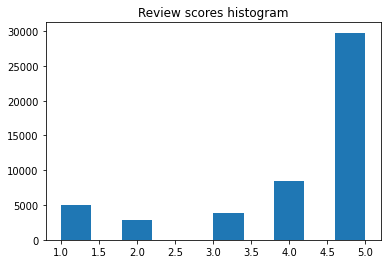

In [ ]:
# preview distribution ## HUGR SKEWNESS
plt.hist(df['Score'])
plt.title('Review scores histogram')


In [ ]:
#drop duplicates, they exist!
print(df.shape)
df_unique = df.drop_duplicates()
print(df_unique.shape)

(50000, 2)
(49357, 2)


Text(0.5, 1.0, 'Unique reviews score histogram')

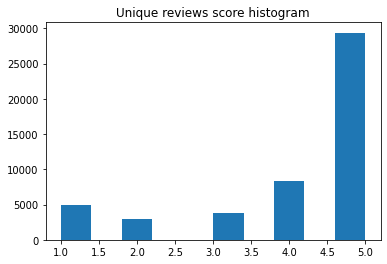

In [ ]:
## STIL SKEWED!!
plt.hist(df_unique['Score'])
plt.title('Unique reviews score histogram')

In [ ]:
## total number of examples of each class
s1 = df_unique[df_unique['Score']==1].count()[0]
s2 = df_unique[df_unique['Score']==2].count()[0]
s3 = df_unique[df_unique['Score']==3].count()[0]
s4 = df_unique[df_unique['Score']==4].count()[0]
s5 = df_unique[df_unique['Score']==5].count()[0]
print(s1, s2, s3, s4, s5)

4979 2882 3850 8276 29370


In [ ]:
def convert_data(df):

  array = []
  embeddArray = []

  #The array will hold all reviews splited in each word in a 2d array 
  for review in df['Text']:
        
    res = re.sub(r'[^\w\s]', '', review)
    res = res.lower()
    array.append(res.split())

    #this loop will convert every word into an embedding and will add them for every review
  for review in array:

    sum = np.zeros((300,))
    counter=0
    for word in review:
      try:
        sum += w2v[word]
        counter += 1
      except:
        continue

    if counter> 0:
      sum = sum / counter
    else:
      sum = np.zeros((300,))
    embeddArray.append(sum)
        
  return np.array(embeddArray)

In [ ]:
## SPLIT UNBALANCED DATA
train_df, test_df = train_test_split(df_unique, train_size=0.8)
X_test = convert_data(test_df)
y_test = test_df['Score']

# BALANCE TRAIN DATA
df_class5 = resample(df_unique[df_unique['Score']==5], 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 ) # reproducible results
df_class4 = resample(df_unique[df_unique['Score']==4], 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 ) # reproducible results
df_class3 = resample(df_unique[df_unique['Score']==3], 
                                 replace=True,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 ) # reproducible results
df_class2 = resample(df_unique[df_unique['Score']==2], 
                                 replace=True,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 ) # reproducible results
df_class1 = resample(df_unique[df_unique['Score']==1], 
                                 replace=True,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 ) # reproducible results

train = pd.concat([df_class1, df_class2, df_class3, df_class4, df_class5])
# shuffle data
train = train.sample(frac = 1)

#convert train data
X = convert_data(train)
y = train['Score']



Text(0.5, 1.0, 'Balanced reviews score histogram')

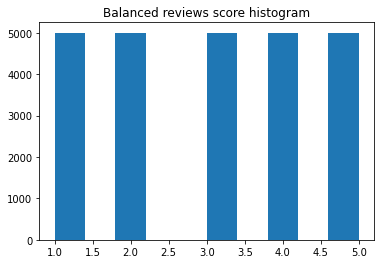

In [ ]:
# better now
plt.hist(train['Score'])
plt.title('Balanced reviews score histogram')

In [ ]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 400, criterion = 'entropy')
classifier.fit(X, y)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.618     0.844     0.714       979
           2      0.912     0.830     0.869       564
           3      0.876     0.749     0.808       717
           4      0.450     0.782     0.571      1716
           5      0.915     0.687     0.785      5896

    accuracy                          0.732      9872
   macro avg      0.754     0.778     0.749      9872
weighted avg      0.802     0.732     0.747      9872



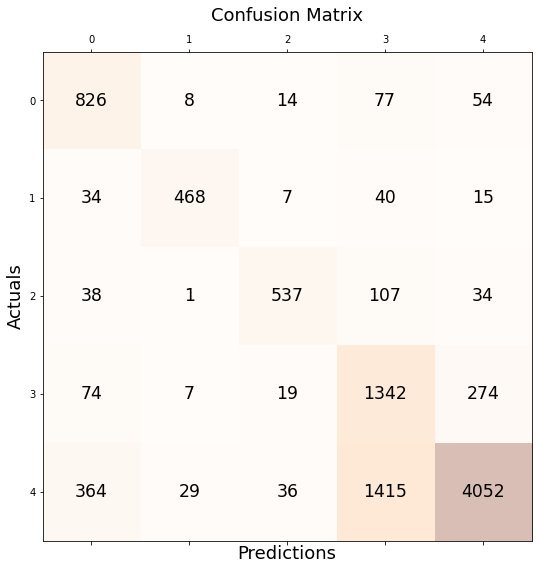

In [ ]:
# Print the confusion matrix using Matplotlib

# The values in the matrix represent 0->1, 1->2, 2->3, 3->4, 4->5

conf_matrix = metrics.confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(figsize=(9, 9))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()